In [1]:
# ------------------------------------
# 单元格 1: 导入所有库
# ------------------------------------
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- 核心 DL 库 (用于任务1) ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# --- Sklearn 库 (用于任务1预处理 和 任务2) ---
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler # 导入两种 Scaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error # 导入 MSE 和 MAPE
from sklearn.decomposition import PCA # 用于可视化

# --- 设置 ---
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Heiti TC'] # 如果您用中文标签，请取消这行注释
# plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

print(f"TensorFlow 版本: {tf.__version__}")
print("所有库导入成功。")

TensorFlow 版本: 2.16.2
所有库导入成功。


In [2]:
# ------------------------------------
# 单元格 2: 全局配置
# ------------------------------------
DB_FILE = 'esi_rankings.db'
TABLE_NAME = 'esi_rankings'
TARGET_INSTITUTION = 'EAST CHINA NORMAL UNIVERSITY'

print(f"数据库文件: {DB_FILE}")
print(f"目标机构: {TARGET_INSTITUTION}")

数据库文件: esi_rankings.db
目标机构: EAST CHINA NORMAL UNIVERSITY


In [3]:
# ------------------------------------
# 单元格 3: 共用函数
# ------------------------------------

def load_data(db_file, table_name):
    """
    从 SQLite 数据库加载数据。
    """
    print(f"正在从 {db_file} 加载数据...")
    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        conn.close()
        print(f"数据加载成功，共 {len(df)} 条记录。")
        return df
    except Exception as e:
        print(f"数据加载失败: {e}")
        return pd.DataFrame()

def get_aggregated_data(df):
    """
    将原始 DataFrame 按机构聚合，构建高校画像 (用于任务2)。
    """
    print("正在按机构聚合数据以构建高校画像...")
    if df.empty:
        print("输入数据为空，无法聚合。")
        return pd.DataFrame(), []
        
    features = [
        'total_subjects', 'avg_rank', 'total_documents', 
        'total_cites', 'total_top_papers', 'avg_cites_per_paper'
    ]
    
    df_agg = df.groupby('institution').agg(
        total_subjects=pd.NamedAgg(column='research_field', aggfunc='count'),
        avg_rank=pd.NamedAgg(column='rank', aggfunc='mean'),
        total_documents=pd.NamedAgg(column='documents', aggfunc='sum'),
        total_cites=pd.NamedAgg(column='cites', aggfunc='sum'),
        total_top_papers=pd.NamedAgg(column='top_papers', aggfunc='sum'),
        avg_cites_per_paper=pd.NamedAgg(column='cites_per_paper', aggfunc='mean') 
    ).reset_index()
    
    print(f"数据聚合完成，共 {len(df_agg)} 所机构。")
    return df_agg, features

print("共用函数 (load_data, get_aggregated_data) 定义完成。")

共用函数 (load_data, get_aggregated_data) 定义完成。


In [4]:
# ------------------------------------
# 单元格 4: 加载原始数据
# ------------------------------------
df_raw = load_data(DB_FILE, TABLE_NAME)

if not df_raw.empty:
    print("\n数据预览 (前5行):")
    print(df_raw.head())

正在从 esi_rankings.db 加载数据...
数据加载成功，共 34121 条记录。

数据预览 (前5行):
   id         research_field  rank  \
0   1  AGRICULTURAL SCIENCES     1   
1   2  AGRICULTURAL SCIENCES     2   
2   3  AGRICULTURAL SCIENCES     3   
3   4  AGRICULTURAL SCIENCES     4   
4   5  AGRICULTURAL SCIENCES     5   

                                      institution  country_region  documents  \
0                     CHINESE ACADEMY OF SCIENCES  CHINA MAINLAND      15661   
1        CHINESE ACADEMY OF AGRICULTURAL SCIENCES  CHINA MAINLAND      12222   
2  UNITED STATES DEPARTMENT OF AGRICULTURE (USDA)             USA      12564   
3                   CHINA AGRICULTURAL UNIVERSITY  CHINA MAINLAND      10052   
4                                           INRAE          FRANCE       9314   

    cites  cites_per_paper  top_papers  
0  332254            21.22         251  
1  223855            18.32         198  
2  220644            17.56         105  
3  207779            20.67         166  
4  187838            20.

In [11]:
# ------------------------------------
# 单元格 5 (改进版): 任务1 - 数据准备 (随机打乱 + 分层抽样)
# ------------------------------------
print("--- 开始执行任务1 (改进版)：深度学习排名预测模型 ---")

# 导入用于拆分的库
from sklearn.model_selection import train_test_split

# 1. 准备数据
df_model = df_raw.dropna(subset=[
    'research_field', 'rank', 'documents', 
    'cites', 'cites_per_paper', 'top_papers'
])

target = 'rank'
numeric_features = ['documents', 'cites', 'cites_per_paper', 'top_papers']
categorical_features = ['research_field']

X = df_model[numeric_features + categorical_features]
# 2. 对数变换目标值 (y)
y = np.log(df_model[target]) # 关键：对 y 进行 log 变换
print(f"步骤 1/4: 已对目标 'rank' 进行 Log 变换。")


# 3. [关键改进]：随机打乱拆分 (80% 训练, 20% 测试)
print("步骤 2/4: 正在进行随机打乱 (Shuffle) 和分层抽样 (Stratify)...")

# 我们使用 train_test_split 来随机拆分数据
# test_size=0.2 表示 20% 的数据作为测试集
# stratify=X['research_field'] 确保每个学科在训练集和测试集中的比例与原始数据一致
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, # 确保每次运行结果一致
    stratify=X['research_field'] # 按学科分层
)

# 保留原始 y_test 以便评估
# 我们从 y_test_log 的索引中找到原始的 rank 值
y_test_orig = df_model.loc[y_test_log.index][target] 

print(f"数据随机拆分完成。")
print(f"  训练集大小: {len(X_train)}")
print(f"  测试集大小: {len(X_test)}")

# 4. 创建数据预处理 Pipeline
print("步骤 3/4: 正在构建数据预处理 Pipeline (StandardScaler + OneHotEncoder)...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features), 
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 5. 应用预处理
# [重要]：预处理器 (preprocessor) 必须在训练集 (X_train) 上 'fit'
# 然后用它来 'transform' 训练集和测试集
print("步骤 4/4: 正在对训练集 'fit' 预处理器并 'transform' 数据...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Keras 需要密集的 numpy 数组
if hasattr(X_train_processed, "toarray"):
    X_train_processed = X_train_processed.toarray()
    X_test_processed = X_test_processed.toarray()

print("数据预处理完成。")
print(f"处理后训练集特征维度: {X_train_processed.shape}")

--- 开始执行任务1 (改进版)：深度学习排名预测模型 ---
步骤 1/4: 已对目标 'rank' 进行 Log 变换。
步骤 2/4: 正在进行随机打乱 (Shuffle) 和分层抽样 (Stratify)...
数据随机拆分完成。
  训练集大小: 27296
  测试集大小: 6825
步骤 3/4: 正在构建数据预处理 Pipeline (StandardScaler + OneHotEncoder)...
步骤 4/4: 正在对训练集 'fit' 预处理器并 'transform' 数据...
数据预处理完成。
处理后训练集特征维度: (27296, 26)


In [12]:
# ------------------------------------
# 单元格 6: 任务1 - 构建深度学习模型 (MLP)
# ------------------------------------

# 获取输入维度
input_dim = X_train_processed.shape[1]

def build_model(input_shape):
    model = Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2), 
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(32, activation='relu'),
        layers.Dense(1) # 输出层 (回归问题)
    ])
    
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', # 损失函数用 MSE
                  metrics=['mean_absolute_error'])
    
    return model

model = build_model(input_dim)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,825 (54.00 KB)

 Trainable params: 13,825 (54.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ------------------------------------
# 单元格 7: 任务1 - 训练模型
# ------------------------------------
print("开始训练深度学习模型...")

# 使用 EarlyStopping 可以在模型不再改进时提前停止训练
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=20,        
    restore_best_weights=True 
)

history = model.fit(
    X_train_processed, 
    y_train_log,
    epochs=100, # 训练 100 轮, 但 EarlyStopping 会提前停止
    batch_size=32,
    validation_split=0.2, # 从训练集中分出 20% 作为验证集
    callbacks=[early_stopping],
    verbose=1 
)

print("模型训练完成。")

开始训练深度学习模型...
Epoch 1/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 7.6332 - mean_absolute_error: 1.2838 - val_loss: 0.8267 - val_mean_absolute_error: 0.6330
Epoch 2/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 7.9564 - mean_absolute_error: 1.3544 - val_loss: 0.9225 - val_mean_absolute_error: 0.6038
Epoch 3/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 18.5334 - mean_absolute_error: 1.6748 - val_loss: 1.7577 - val_mean_absolute_error: 0.4860
Epoch 4/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 6.4972 - mean_absolute_error: 1.2122 - val_loss: 94.4050 - val_mean_absolute_error: 5.1616
Epoch 5/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 9.2174 - mean_absolute_error: 1.4926 - val_loss: 2.5527 - val_mean_absolute_error: 1.1138
Epoch 6/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 47.1111 - mean_absolute_error: 2.8368 - val_loss: 32.2156 - val_mean_absolute_error: 2.9551
Epoch 7/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 259.1045

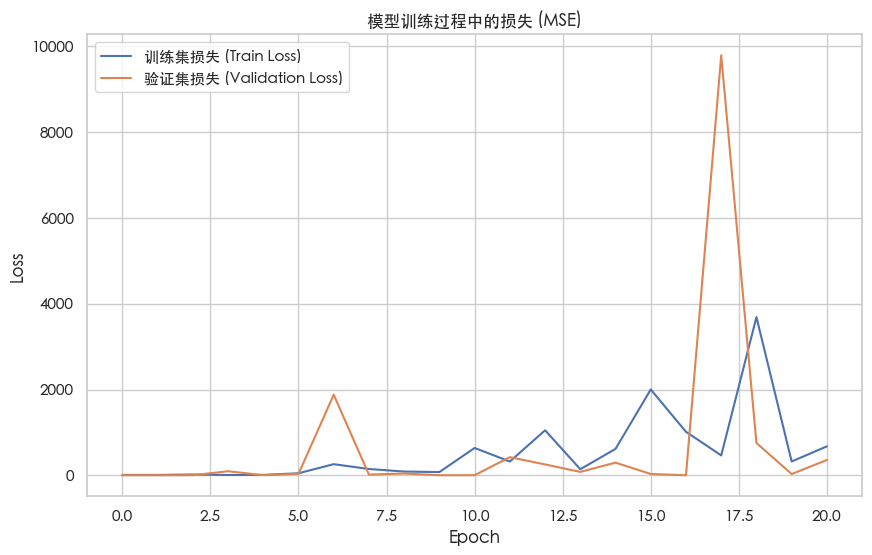


正在测试集上评估模型...
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

--- 任务1 结果：深度学习模型评估 (测试集) ---
MSE (均方误差): 47523276.0000
MAPE (平均绝对百分比误差): 1.6086 (预测平均偏离 160.86%)
RMSE (均方根误差): 6893.7128 (预测排名平均误差约 6894 名)

--- 预测结果抽样对比 (前20条) ---
    真实排名 (Actual Rank)  预测排名 (Predicted Rank)
0                  924            1034.654663
1                 1385            1088.666870
2                  948             961.737000
3                   32             439.364777
4                  292             203.373352
5                 2529            4309.211426
6                 1776            1569.565186
7                 2100            1185.154175
8                 1644            1641.129639
9                 2897            4149.728516
10                 358             685.589905
11                 328             635.259094
12                1048            1062.924683
13                1216            3585.914062
14                1646             925.419312
15                 793            1039.29

In [21]:
# ------------------------------------
# 单元格 8: 任务1 - 评估模型 (MSE, MAPE)
# ------------------------------------

# 1. 绘制训练过程中的损失
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='训练集损失 (Train Loss)')
plt.plot(history.history['val_loss'], label='验证集损失 (Validation Loss)')
plt.title('模型训练过程中的损失 (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('dl_loss_curve.png')
plt.show()

# 2. 在测试集上评估
print("\n正在测试集上评估模型...")
# 预测 log(rank)
y_pred_log = model.predict(X_test_processed).flatten()

# 3. 还原预测值
# 关键：将 log(rank) 转换回 rank
y_pred_orig = np.exp(y_pred_log)

# 4. 计算 MSE 和 MAPE (按作业要求)
mse = mean_squared_error(y_test_orig, y_pred_orig)
mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse) # RMSE 只是 MSE 的平方根，更具解释性

print("\n--- 任务1 结果：深度学习模型评估 (测试集) ---")
print(f"MSE (均方误差): {mse:.4f}")
print(f"MAPE (平均绝对百分比误差): {mape:.4f} (预测平均偏离 {mape*100:.2f}%)")
print(f"RMSE (均方根误差): {rmse:.4f} (预测排名平均误差约 {rmse:.0f} 名)")


# 5. 抽样对比真实值和预测值
print("\n--- 预测结果抽样对比 (前20条) ---")
df_compare = pd.DataFrame({
    '真实排名 (Actual Rank)': y_test_orig.values,
    '预测排名 (Predicted Rank)': y_pred_orig
})
print(df_compare.head(20))

In [22]:
# ------------------------------------
# 单元格 9: 任务2 - 稳健聚类与相似性分析 (优化版)
# ------------------------------------
print("\n--- 开始执行任务2 (优化版)：稳健聚类与相似高校分析 ---")

# 1. 获取聚合数据
df_agg, agg_features = get_aggregated_data(df_raw)

if not df_agg.empty:
    df_agg_processed = df_agg.set_index('institution')[agg_features].fillna(0).copy()

    # 2. [优化]：对数变换 (Log Transform)
    log_features = ['total_documents', 'total_cites', 'total_top_papers']
    print(f"步骤 1/5: 正在对 {log_features} 应用 Log(1+p) 变换...")
    for col in log_features:
        df_agg_processed[col] = df_agg_processed[col].apply(lambda x: np.log1p(x if x > 0 else 0))

    # 3. [优化]：使用 RobustScaler
    print("步骤 2/5: 正在使用 RobustScaler (稳健标准化)...")
    scaler = RobustScaler() 
    features_scaled = scaler.fit_transform(df_agg_processed)
    df_scaled = pd.DataFrame(features_scaled, index=df_agg_processed.index, columns=agg_features)

    # 4. K-Means 聚类 (K=5)
    K = 5
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    df_agg['cluster'] = kmeans.fit_predict(features_scaled)
    df_scaled['cluster'] = df_agg['cluster'].values
    print(f"步骤 3/5: K-Means 聚类完成 (K={K})。")

    # 5. 分析华师大所在的聚类
    try:
        ecnu_cluster = df_scaled.loc[TARGET_INSTITUTION]['cluster']
        print(f"\n--- 任务2 结果 (聚类) ---")
        print(f"'{TARGET_INSTITUTION}' 位于聚类: {int(ecnu_cluster)}")

        # 6. 分析原因：查看该聚类的中心特征
        print("\n[分析原因]: 华师大所在聚类的中心特征 (标准化后) 如下:")
        cluster_center = df_scaled[df_scaled['cluster'] == ecnu_cluster][agg_features].mean()
        print(cluster_center)
        print(f"\n华师大自身的特征 (标准化后):")
        print(df_scaled.loc[TARGET_INSTITUTION][agg_features])
        print("-> 原因：华师大在学科广度、平均排名、总产出(经对数变换和稳健标准化后)等方面的画像与该聚类的平均水平接近。")

        # 7. 寻找相似高校 (欧氏距离)
        print(f"\n步骤 4/5: 正在寻找与 '{TARGET_INSTITUTION}' 最相似的近邻...")
        target_vector_scaled = df_scaled.loc[TARGET_INSTITUTION][agg_features].values.reshape(1, -1)
        distances = euclidean_distances(target_vector_scaled, df_scaled[agg_features].values)
        df_scaled['distance_to_target'] = distances[0]
        
        df_similar_euclidean = df_scaled.sort_values(by='distance_to_target', ascending=True)
        top_similar_euclidean = df_similar_euclidean.iloc[0:11]
        
        # 提取原始聚合数据 (未经 log 变换) 以提高可读性
        original_data_similar = df_agg.set_index('institution').loc[top_similar_euclidean.index]
        original_data_similar['distance'] = top_similar_euclidean['distance_to_target']
        
        print(f"\n--- 任务2 结果 (近邻) ---")
        print(f"与 {TARGET_INSTITUTION} 画像最相似的10所高校 (基于优化后的空间):")
        print(original_data_similar[['total_subjects', 'avg_rank', 'avg_cites_per_paper', 'distance']])
        print("步骤 5/5: 相似高校分析完成。")

    except KeyError:
        print(f"错误：在数据中未找到机构 '{TARGET_INSTITUTION}'。")
    except Exception as e:
        print(f"执行任务2时出错: {e}")
else:
    print("聚合数据为空，跳过任务2。")


--- 开始执行任务2 (优化版)：稳健聚类与相似高校分析 ---
正在按机构聚合数据以构建高校画像...
数据聚合完成，共 9990 所机构。
步骤 1/5: 正在对 ['total_documents', 'total_cites', 'total_top_papers'] 应用 Log(1+p) 变换...
步骤 2/5: 正在使用 RobustScaler (稳健标准化)...
步骤 3/5: K-Means 聚类完成 (K=5)。

--- 任务2 结果 (聚类) ---
'EAST CHINA NORMAL UNIVERSITY' 位于聚类: 0

[分析原因]: 华师大所在聚类的中心特征 (标准化后) 如下:
total_subjects         0.887123
avg_rank               0.190960
total_documents        0.154672
total_cites            0.216767
total_top_papers       0.203945
avg_cites_per_paper    0.621544
dtype: float64

华师大自身的特征 (标准化后):
total_subjects         5.333333
avg_rank              -0.441788
total_documents        1.479737
total_cites            1.628462
total_top_papers       1.646192
avg_cites_per_paper   -0.175750
Name: EAST CHINA NORMAL UNIVERSITY, dtype: float64
-> 原因：华师大在学科广度、平均排名、总产出(经对数变换和稳健标准化后)等方面的画像与该聚类的平均水平接近。

步骤 4/5: 正在寻找与 'EAST CHINA NORMAL UNIVERSITY' 最相似的近邻...

--- 任务2 结果 (近邻) ---
与 EAST CHINA NORMAL UNIVERSITY 画像最相似的10所高校 (基于优化后的空间):
                           


--- 开始执行 任务2 (可视化部分) ---
步骤 1/4: 正在使用 PCA 进行降维 (6D -> 2D)...
步骤 2/4: PCA 降维完成。总共解释了 99.89% 的方差
步骤 3/4: 正在绘制聚类散点图...
步骤 4/4: 正在图上标记 EAST CHINA NORMAL UNIVERSITY...


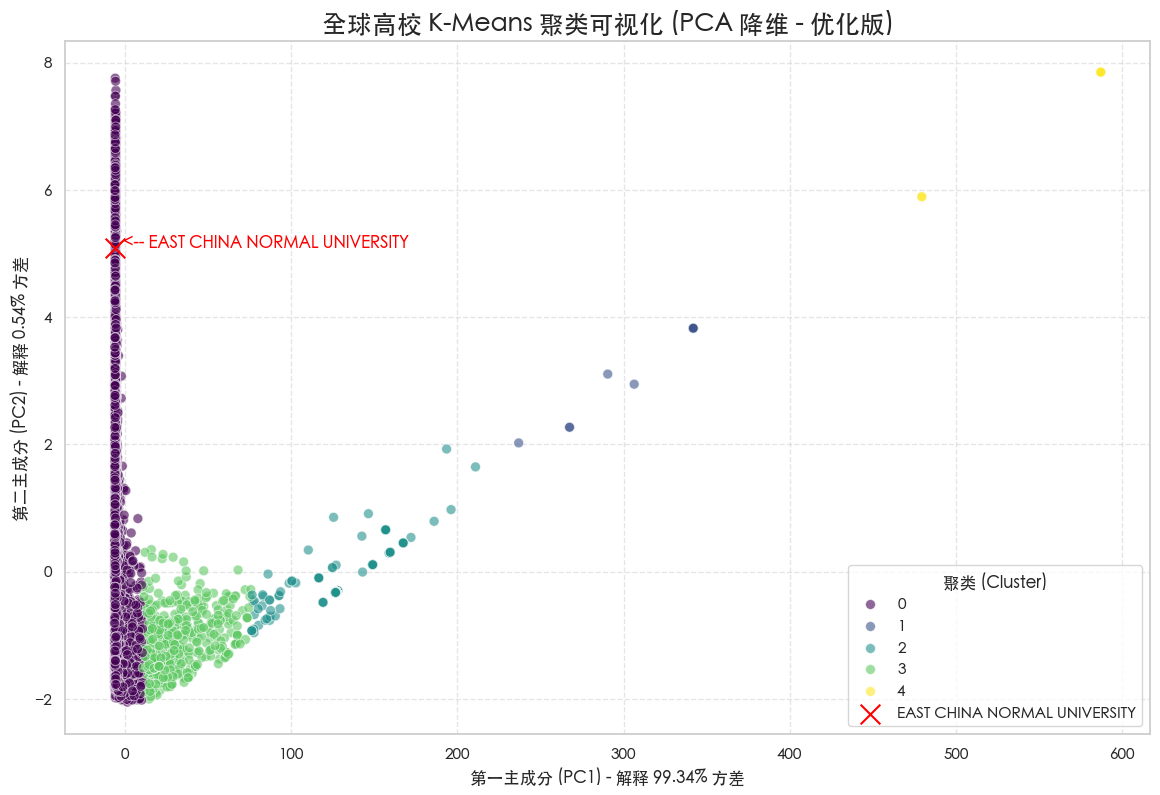

In [23]:
# ------------------------------------
# 单元格 10: 任务2 - 聚类可视化 (PCA 降维)
# (依赖 单元格 9 的运行结果)
# ------------------------------------
print("\n--- 开始执行 任务2 (可视化部分) ---")

if 'df_scaled' in locals() and 'df_agg' in locals() and 'agg_features' in locals():
    print("步骤 1/4: 正在使用 PCA 进行降维 (6D -> 2D)...")
    
    features_to_reduce = df_scaled[agg_features] 
    pca = PCA(n_components=2) 
    pca_result = pca.fit_transform(features_to_reduce)
    
    df_viz = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    df_viz['cluster'] = df_agg['cluster'].values 
    df_viz['institution'] = df_agg['institution'].values 
    
    print(f"步骤 2/4: PCA 降维完成。总共解释了 {np.sum(pca.explained_variance_ratio_):.2%} 的方差")

    print("步骤 3/4: 正在绘制聚类散点图...")
    plt.figure(figsize=(14, 9))
    
    sns.scatterplot(
        data=df_viz,
        x='PC1',
        y='PC2',
        hue='cluster',
        palette='viridis', 
        s=50,
        alpha=0.6,
        legend='full'
    )
    
    print(f"步骤 4/4: 正在图上标记 {TARGET_INSTITUTION}...")
    try:
        ecnu_viz = df_viz[df_viz['institution'] == TARGET_INSTITUTION].iloc[0]
        
        plt.scatter(
            ecnu_viz['PC1'], 
            ecnu_viz['PC2'], 
            marker='x',
            color='red',
            s=200,
            label=TARGET_INSTITUTION,
            zorder=5 
        )
        plt.text(
            ecnu_viz['PC1'] + 0.05,
            ecnu_viz['PC2'], 
            f"  <-- {TARGET_INSTITUTION}",
            horizontalalignment='left', 
            color='red', 
            weight='bold',
            fontsize=12
        )
        
    except IndexError:
        print(f"警告: 未能在可视化数据中找到 {TARGET_INSTITUTION} 进行标记。")

    plt.title('全球高校 K-Means 聚类可视化 (PCA 降维 - 优化版)', fontsize=18)
    plt.xlabel(f'第一主成分 (PC1) - 解释 {pca.explained_variance_ratio_[0]:.2%} 方差', fontsize=12)
    plt.ylabel(f'第二主成分 (PC2) - 解释 {pca.explained_variance_ratio_[1]:.2%} 方差', fontsize=12)
    plt.legend(title='聚类 (Cluster)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig('task2_cluster_visualization_pca_optimized.png')
    plt.show()

else:
    print("错误：未找到 Cell 9 中生成的 'df_scaled' 或 'df_agg'。请先运行 Cell 9。")